In [1]:
import matplotlib.pyplot as plt
import os,glob,imp
import numpy as np
import seaborn as sns
import pyslha, copy, pickle
from matplotlib import colors
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    return levelPts

In [3]:
#Get SModelS results:
outputFolder = './results/smodels/'
slhaFolder = './slha'
data = []
for slha in glob.glob(os.path.join(slhaFolder,'*.slha')):
    fname = os.path.basename(slha)
    sname = os.path.join(outputFolder,fname+'.py')
    if not os.path.isfile(sname):
        continue
    slhaData = pyslha.readSLHAFile(slha)
    mHSCP = slhaData.blocks['MASS'][1000015]
    width = slhaData.decays[1000015].totalwidth
    xsec = slhaData.xsections[(2212,2212,-1000015,1000015)].xsecs[0].value
    with open(sname,'r') as f:
        exec(f.read())
    if not 'ExptRes' in smodelsOutput:
        rmax = 0.0
    else:
        rmax = max([exp['r'] for exp in smodelsOutput['ExptRes']])
    data.append((mHSCP,width,xsec,rmax))

In [4]:
columns = ['mHSCP','width','xsec','r']
dt=np.dtype({"names": columns, "formats" : ['<f8'] *len(columns)})
smodelsData = np.array(data,dtype=dt)
smodelsData.sort(order=['mHSCP','width'])

In [5]:
#Get Pythia results:
outputFolder = './results/pythia'
slhaFolder = './slha'
data = []
UL = {'c000' : 1.2, 'c100' : 0.451, 'c200' : 0.18, 'c300' : 0.164}
for f in glob.glob(os.path.join(outputFolder,'*.eff')):
    fname = os.path.basename(f)
    slha = os.path.join(slhaFolder,fname.replace('.eff','_1.00e-25.slha'))
    slhaData = pyslha.readSLHAFile(slha)
    mHSCP = slhaData.blocks['MASS'][1000015]
    effData = np.genfromtxt(f,names=True)
    xsec = slhaData.xsections[(2212,2212,-1000015,1000015)].xsecs[0].value
    rValues = {}
    for i,pt in enumerate(effData):
        width = pt['width']
        rmax = max([effData[SR][i]*xsec*1000/UL[SR] for SR in UL])
        eff = max([effData[SR][i] for SR in UL])
        data.append((mHSCP,width,xsec,rmax,eff))

In [6]:
columns = ['mHSCP','width','xsec','r','eff']
dt=np.dtype({"names": columns, "formats" : ['<f8'] *len(columns)})
pythiaData = np.array(data,dtype=dt)
pythiaData.sort(order=['mHSCP','width'])

In [7]:
smodelsCurve = getContour(smodelsData['mHSCP'],np.log(smodelsData['width']),smodelsData['r'],[1.0])[1.0][0]
smodelsCurve = np.array([[x[0],np.exp(x[1])] for x in smodelsCurve])

pythiaCurve = getContour(pythiaData['mHSCP'],np.log(pythiaData['width']),pythiaData['r'],[1.0])[1.0][0]
pythiaCurve = np.array([[x[0],np.exp(x[1])] for x in pythiaCurve])

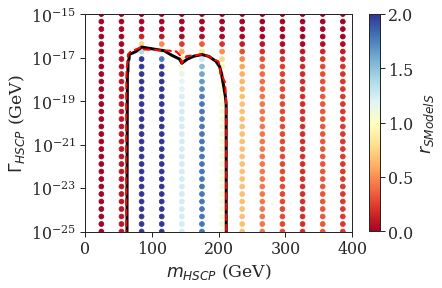

In [11]:
plt.scatter(smodelsData['mHSCP'],smodelsData['width'],c=smodelsData['r'],vmin=0,vmax=2.0,
           cmap=plt.cm.get_cmap('RdYlBu'))
plt.plot(smodelsCurve[:,0],smodelsCurve[:,1],linewidth=3.0,c='black')
plt.plot(pythiaCurve[:,0],smodelsCurve[:,1],linewidth=2.0,c='red',linestyle='--')
plt.colorbar(label=r'$r_{SModelS}$')
plt.xlim(0,400)
plt.yscale('log')
plt.ylim(1e-25,1e-15)
plt.xlabel(r'$m_{HSCP}$ (GeV)')
plt.ylabel(r'$\Gamma_{HSCP}$ (GeV)')
plt.show()

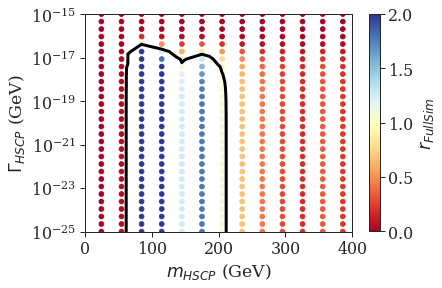

In [12]:
plt.scatter(pythiaData['mHSCP'],pythiaData['width'],c=pythiaData['r'],vmin=0,vmax=2.0,
            cmap=plt.cm.get_cmap('RdYlBu'))
plt.plot(pythiaCurve[:,0],pythiaCurve[:,1],linewidth=3.0,c='black')
plt.colorbar(label=r'$r_{FullSim}$')
plt.xlim(0,400)
plt.yscale('log')
plt.ylim(1e-25,1e-15)
plt.xlabel(r'$m_{HSCP}$ (GeV)')
plt.ylabel(r'$\Gamma_{HSCP}$ (GeV)')
plt.show()

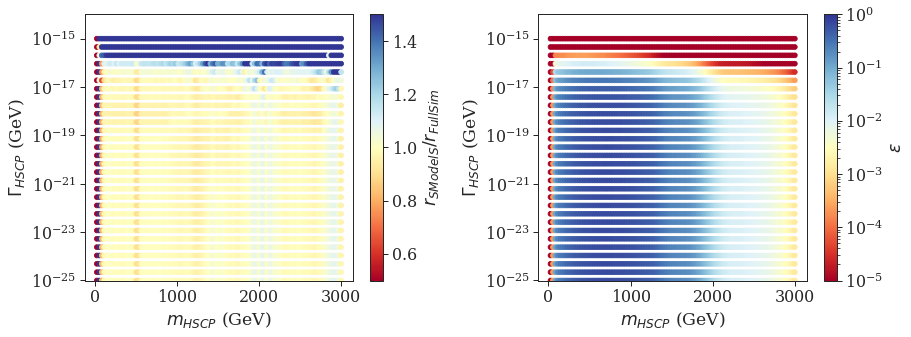

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5))
ratio = np.divide(smodelsData['r'],pythiaData['r'],where=pythiaData['r'] > 0)
a = ax[0].scatter(pythiaData['mHSCP'],pythiaData['width'],c=ratio,vmin=0.5,vmax=1.5,
            cmap=plt.cm.get_cmap('RdYlBu'))

fig.colorbar(a, ax=ax[0], label = r'$r_{SModelS}/r_{FullSim}$')
# ax[0].set_xlim(1500,2500)
ax[0].set_yscale('log')
ax[0].set_ylim(1e-25,1e-14)
ax[0].set_xlabel(r'$m_{HSCP}$ (GeV)')
ax[0].set_ylabel(r'$\Gamma_{HSCP}$ (GeV)')

a = ax[1].scatter(pythiaData['mHSCP'],pythiaData['width'],c=pythiaData['eff'],vmin=1e-5,vmax=1.0,
            cmap=plt.cm.get_cmap('RdYlBu'), norm=colors.LogNorm())

fig.colorbar(a, ax=ax[1], label=r'$\epsilon$')
# ax[1].set_xlim(1500,2500)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-25,1e-14)
ax[1].set_xlabel(r'$m_{HSCP}$ (GeV)')
ax[1].set_ylabel(r'$\Gamma_{HSCP}$ (GeV)')
plt.tight_layout()
plt.show()

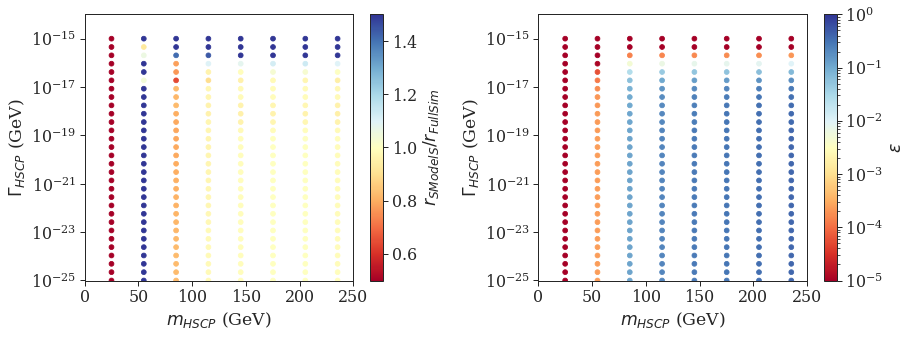

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5))
ratio = np.divide(smodelsData['r'],pythiaData['r'],where=pythiaData['r'] > 0)
a = ax[0].scatter(pythiaData['mHSCP'],pythiaData['width'],c=ratio,vmin=0.5,vmax=1.5,
            cmap=plt.cm.get_cmap('RdYlBu'))

fig.colorbar(a, ax=ax[0], label = r'$r_{SModelS}/r_{FullSim}$')
ax[0].set_xlim(0,250)
ax[0].set_yscale('log')
ax[0].set_ylim(1e-25,1e-14)
ax[0].set_xlabel(r'$m_{HSCP}$ (GeV)')
ax[0].set_ylabel(r'$\Gamma_{HSCP}$ (GeV)')

a = ax[1].scatter(pythiaData['mHSCP'],pythiaData['width'],c=pythiaData['eff'],vmin=1e-5,vmax=1.0,
            cmap=plt.cm.get_cmap('RdYlBu'), norm=colors.LogNorm())

fig.colorbar(a, ax=ax[1], label=r'$\epsilon$')
ax[1].set_xlim(0,250)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-25,1e-14)
ax[1].set_xlabel(r'$m_{HSCP}$ (GeV)')
ax[1].set_ylabel(r'$\Gamma_{HSCP}$ (GeV)')
plt.tight_layout()
plt.show()